<a href="https://colab.research.google.com/github/tank671/deepdonald/blob/master/burn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Our project is on classifying burn depth.  We started out using the dataset curated by Cohort 13.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import sys

from pathlib import Path
from fastai.vision import *
from fastai.callbacks import *
from google.colab import drive
from fastai import *

In [0]:
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/gdrive/My Drive/exp')
sys.path.append('/content/gdrive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Assembling data

The data are in an Imagenet-style hierarchy, with web-scraped images in the train and valid folders and images from a burn atlas in the test folder.  The three classes are 1, 2, and 3, with the training set also including non-burn images (labelled 'none').

In [0]:
#path = Path('/content/drive/My Drive/burn/burn-tv-cur-final')
path.ls()

[PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/test'),
 PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/train'),
 PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/valid'),
 PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/models')]

In [0]:
(path/'valid').ls()

[PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/valid/1'),
 PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/valid/2'),
 PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/valid/3')]

In [0]:
tfms = get_transforms(flip_vert=True)

In [0]:
data = ImageDataBunch.from_folder(path, train='train', valid='valid', ds_tfms=tfms, size=64).normalize(imagenet_stats)

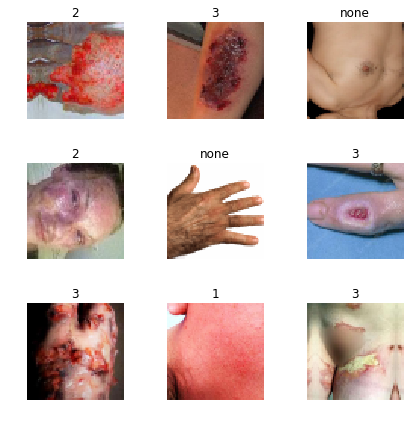

In [0]:
data.show_batch(rows=3, figsize=(6, 6))

In [0]:
print(data.classes)

['1', '2', '3', 'none']


# Training: ResNet-18

As a first step, I started training with ResNet-18 to get a lower bound on accuracy.  My initial strategy was to use smaller versions of the images to pre-train the network, and to gradually increase the size.  With this combination of image size and network, training goes pretty fast.  I was curious to see how long I could train for without overfitting (I've encountered in multiple places the advice to start training by *trying* to overfit your model), so I trained for 80 epochs, which still does not appear to be overfitting.

In [0]:
learn1 = cnn_learner(data, models.resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 89094351.58it/s]


In [0]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


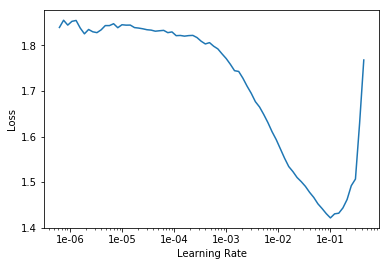

In [0]:
learn1.recorder.plot()

In [0]:
learn1.fit_one_cycle(80, 3e-4, pct_start=0.5, callbacks=[SaveModelCallback(learn1, every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,time
0,1.850755,1.659979,0.250000,01:19
1,1.838765,1.662379,0.229167,00:09
2,1.845649,1.651302,0.260417,00:06
3,1.823384,1.658795,0.270833,00:06
4,1.823939,1.638120,0.270833,00:07
5,1.806032,1.633685,0.281250,00:06
6,1.796860,1.608400,0.270833,00:06
7,1.789972,1.581613,0.291667,00:06
8,1.770053,1.574785,0.302083,00:06
9,1.754464,1.518868,0.322917,00:06


Better model found at epoch 0 with accuracy value: 0.25.
Better model found at epoch 2 with accuracy value: 0.2604166567325592.
Better model found at epoch 3 with accuracy value: 0.2708333432674408.
Better model found at epoch 5 with accuracy value: 0.28125.
Better model found at epoch 7 with accuracy value: 0.2916666567325592.
Better model found at epoch 8 with accuracy value: 0.3020833432674408.
Better model found at epoch 9 with accuracy value: 0.3229166567325592.
Better model found at epoch 11 with accuracy value: 0.3333333432674408.
Better model found at epoch 13 with accuracy value: 0.3541666567325592.
Better model found at epoch 14 with accuracy value: 0.3645833432674408.
Better model found at epoch 15 with accuracy value: 0.375.
Better model found at epoch 16 with accuracy value: 0.3854166567325592.
Better model found at epoch 17 with accuracy value: 0.40625.
Better model found at epoch 18 with accuracy value: 0.4479166567325592.
Better model found at epoch 20 with accuracy val

In [0]:
learn1.save()

# Adding mixup into the mix

A recent addition to the fastai library is the mixup data augmentation strategy.  It looks very easy to add, so I tried it below, with shockingly good results...

In [0]:
learn2 = cnn_learner(data, models.resnet18, metrics=accuracy).mixup()

In [0]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


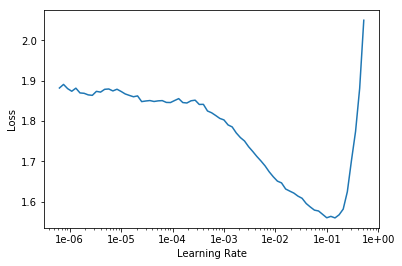

In [0]:
learn2.recorder.plot()

In [0]:
learn2.fit_one_cycle(100, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn2, every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,time
0,1.719931,1.310226,0.395833,00:05
1,1.629614,1.239295,0.479167,00:07
2,1.541377,1.175461,0.489583,00:07
3,1.482133,1.105641,0.500000,00:06
4,1.428920,1.049847,0.520833,00:07
5,1.379946,1.007433,0.552083,00:06
6,1.332906,0.942501,0.614583,00:06
7,1.291692,0.909021,0.572917,00:06
8,1.260102,0.836032,0.625000,00:06
9,1.222643,0.773453,0.697917,00:06


Better model found at epoch 0 with accuracy value: 0.3958333432674408.
Better model found at epoch 1 with accuracy value: 0.4791666567325592.
Better model found at epoch 2 with accuracy value: 0.4895833432674408.
Better model found at epoch 3 with accuracy value: 0.5.
Better model found at epoch 4 with accuracy value: 0.5208333134651184.
Better model found at epoch 5 with accuracy value: 0.5520833134651184.
Better model found at epoch 6 with accuracy value: 0.6145833134651184.
Better model found at epoch 8 with accuracy value: 0.625.
Better model found at epoch 9 with accuracy value: 0.6979166865348816.
Better model found at epoch 10 with accuracy value: 0.71875.
Better model found at epoch 16 with accuracy value: 0.7395833134651184.
Better model found at epoch 18 with accuracy value: 0.75.
Better model found at epoch 20 with accuracy value: 0.78125.
Better model found at epoch 22 with accuracy value: 0.8125.
Better model found at epoch 24 with accuracy value: 0.8229166865348816.
Bette

In [0]:
accuracy(*learn2.get_preds())

tensor(0.9896)

In [0]:
learn2.save('resnet18_mixup_64_stage1')

In [0]:
accuracy(*learn2.get_preds(ds_type = data.train_ds))

tensor(0.9723)

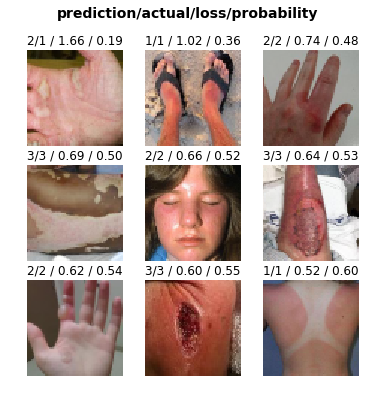

In [0]:
interp = ClassificationInterpretation.from_learner(learn2)
losses, idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(6, 6))

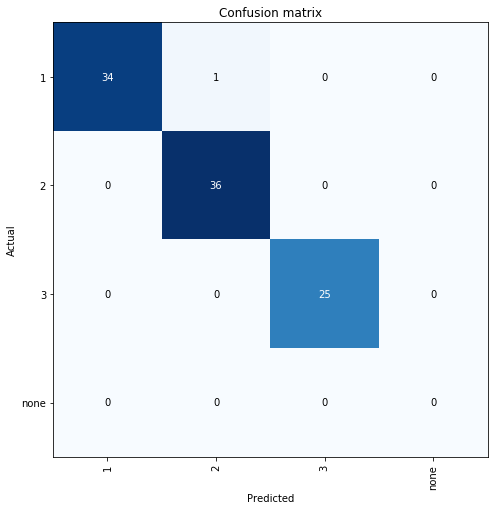

In [0]:
interp.plot_confusion_matrix(figsize=(7, 7))

Even if mixup is great, 97% accuracy seems too good to be true.  I decided to investigate further.

# What if I use all the data (from train, valid, and test folders) and split into train/validation sets randomly with different random seeds?

## Test 1

Training without mixup for 80 epochs: best accuracy 0.754

Training with mixup for 100 epochs: best accuracy 0.808

In [0]:
np.random.seed(0)
data1 = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=tfms, size=64).normalize(imagenet_stats)

In [0]:
learn_1 = cnn_learner(data1, models.resnet18, metrics=accuracy)

In [0]:
learn_1.fit_one_cycle(80, 3e-4, pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1')])

epoch,train_loss,valid_loss,accuracy,time
0,1.704098,1.798365,0.203593,00:17
1,1.769229,1.676740,0.233533,00:08
2,1.769533,1.637165,0.233533,00:08
3,1.785373,1.614762,0.245509,00:07
4,1.783878,1.602467,0.281437,00:07
5,1.776902,1.585081,0.275449,00:07
6,1.770317,1.565927,0.275449,00:07
7,1.758038,1.545317,0.281437,00:07
8,1.753684,1.512519,0.311377,00:07
9,1.736737,1.460793,0.323353,00:07


Better model found at epoch 0 with accuracy value: 0.20359280705451965.
Better model found at epoch 1 with accuracy value: 0.23353293538093567.
Better model found at epoch 3 with accuracy value: 0.24550898373126984.
Better model found at epoch 4 with accuracy value: 0.28143712878227234.
Better model found at epoch 8 with accuracy value: 0.31137725710868835.
Better model found at epoch 9 with accuracy value: 0.32335329055786133.
Better model found at epoch 10 with accuracy value: 0.34730538725852966.
Better model found at epoch 11 with accuracy value: 0.3652694523334503.
Better model found at epoch 12 with accuracy value: 0.371257483959198.
Better model found at epoch 13 with accuracy value: 0.401197612285614.
Better model found at epoch 14 with accuracy value: 0.43113771080970764.
Better model found at epoch 15 with accuracy value: 0.473053902387619.
Better model found at epoch 17 with accuracy value: 0.49700599908828735.
Better model found at epoch 18 with accuracy value: 0.5568862557

In [0]:
learn_1m = cnn_learner(data1, models.resnet18, metrics=accuracy).mixup()

In [0]:
learn_1m.fit_one_cycle(100, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_1m, every='improvement', monitor='accuracy', name='best_1m')])

epoch,train_loss,valid_loss,accuracy,time
0,1.823314,1.307174,0.383234,00:07
1,1.702043,1.139767,0.485030,00:07
2,1.616423,1.041219,0.520958,00:07
3,1.559729,1.010284,0.520958,00:07
4,1.508317,0.971532,0.568862,00:08
5,1.462278,0.927646,0.580838,00:07
6,1.398106,0.891974,0.598802,00:07
7,1.381319,0.900209,0.610778,00:07
8,1.344427,0.913459,0.628743,00:07
9,1.310118,0.918275,0.604790,00:07


Better model found at epoch 0 with accuracy value: 0.38323354721069336.
Better model found at epoch 1 with accuracy value: 0.485029935836792.
Better model found at epoch 2 with accuracy value: 0.5209580659866333.
Better model found at epoch 4 with accuracy value: 0.56886225938797.
Better model found at epoch 5 with accuracy value: 0.5808383226394653.
Better model found at epoch 6 with accuracy value: 0.598802387714386.
Better model found at epoch 7 with accuracy value: 0.6107784509658813.
Better model found at epoch 8 with accuracy value: 0.628742516040802.
Better model found at epoch 10 with accuracy value: 0.652694582939148.
Better model found at epoch 12 with accuracy value: 0.6706587076187134.
Better model found at epoch 13 with accuracy value: 0.682634711265564.
Better model found at epoch 15 with accuracy value: 0.7065868377685547.
Better model found at epoch 19 with accuracy value: 0.742514967918396.
Better model found at epoch 20 with accuracy value: 0.772455096244812.
Better m

In [0]:
data.train_ds

LabelList (686 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
2,2,2,2,2
Path: /content/drive/My Drive/burn/burn-tv-cur-final

In [0]:
data1.train_ds

LabelList (671 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,1,1,1,1
Path: /content/drive/My Drive/burn/burn-tv-cur-final

In [0]:
data.valid_ds

LabelList (96 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,1,1,1,1
Path: /content/drive/My Drive/burn/burn-tv-cur-final

In [0]:
data1.valid_ds

LabelList (167 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,2,3,2,3
Path: /content/drive/My Drive/burn/burn-tv-cur-final

In [0]:
len(data.train_ds) + len(data.valid_ds), len(data1.train_ds) + len(data1.valid_ds)

(782, 838)

[PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/test/1'),
 PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/test/2'),
 PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/test/3')]

## Test 2

Training for 100 epochs

Without mixup: 0.820 accuracy

With mixup: 0.850

In [0]:
np.random.seed(2)
data2 = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=tfms, size=64).normalize(imagenet_stats)

In [0]:
learn_2 = cnn_learner(data2, models.resnet18, metrics=accuracy)
learn_2m = cnn_learner(data2, models.resnet18, metrics=accuracy).mixup()

In [0]:
learn_2.fit_one_cycle(100, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_2, every='improvement', monitor='accuracy', name='best_2')])

epoch,train_loss,valid_loss,accuracy,time
0,1.699712,1.242175,0.485030,00:07
1,1.560464,1.094759,0.550898,00:07
2,1.435167,1.024419,0.538922,00:07
3,1.332867,0.984573,0.568862,00:08
4,1.272191,0.937285,0.568862,00:08
5,1.205542,0.892734,0.586826,00:07
6,1.139795,0.877747,0.622755,00:07
7,1.089358,0.875154,0.634731,00:07
8,1.038682,0.847407,0.640719,00:08
9,0.994936,0.821712,0.628743,00:07


Better model found at epoch 0 with accuracy value: 0.485029935836792.
Better model found at epoch 1 with accuracy value: 0.5508981943130493.
Better model found at epoch 3 with accuracy value: 0.56886225938797.
Better model found at epoch 5 with accuracy value: 0.5868263244628906.
Better model found at epoch 6 with accuracy value: 0.6227545142173767.
Better model found at epoch 7 with accuracy value: 0.6347305178642273.
Better model found at epoch 8 with accuracy value: 0.6407185792922974.
Better model found at epoch 10 with accuracy value: 0.652694582939148.
Better model found at epoch 12 with accuracy value: 0.6646706461906433.
Better model found at epoch 13 with accuracy value: 0.6706587076187134.
Better model found at epoch 14 with accuracy value: 0.7065868377685547.
Better model found at epoch 16 with accuracy value: 0.71257483959198.
Better model found at epoch 18 with accuracy value: 0.7305389046669006.
Better model found at epoch 22 with accuracy value: 0.772455096244812.
Better

In [0]:
learn_2m.fit_one_cycle(100, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_2m, every='improvement', monitor='accuracy', name='best_2m')])

epoch,train_loss,valid_loss,accuracy,time
0,1.728792,1.396392,0.353293,00:07
1,1.638110,1.205965,0.443114,00:07
2,1.571676,1.112519,0.520958,00:07
3,1.501256,1.048995,0.550898,00:07
4,1.436890,1.020783,0.568862,00:07
5,1.382183,0.991363,0.568862,00:07
6,1.349663,0.975663,0.556886,00:07
7,1.317345,0.960325,0.562874,00:07
8,1.281378,0.945614,0.562874,00:07
9,1.250058,0.941784,0.592814,00:07


Better model found at epoch 0 with accuracy value: 0.35329341888427734.
Better model found at epoch 1 with accuracy value: 0.443113774061203.
Better model found at epoch 2 with accuracy value: 0.5209580659866333.
Better model found at epoch 3 with accuracy value: 0.5508981943130493.
Better model found at epoch 4 with accuracy value: 0.56886225938797.
Better model found at epoch 9 with accuracy value: 0.5928143858909607.
Better model found at epoch 10 with accuracy value: 0.6047903895378113.
Better model found at epoch 11 with accuracy value: 0.628742516040802.
Better model found at epoch 12 with accuracy value: 0.6347305178642273.
Better model found at epoch 14 with accuracy value: 0.6407185792922974.
Better model found at epoch 17 with accuracy value: 0.658682644367218.
Better model found at epoch 19 with accuracy value: 0.71257483959198.
Better model found at epoch 21 with accuracy value: 0.71856290102005.
Better model found at epoch 22 with accuracy value: 0.742514967918396.
Better 

## Test 3

Training for 100 epochs

Without mixup: 0.778

With mixup: 0.790

In [0]:
np.random.seed(3)
data3 = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=tfms, size=64).normalize(imagenet_stats)

In [0]:
learn_3 = cnn_learner(data3, models.resnet18, metrics=accuracy)
learn_3m = cnn_learner(data3, models.resnet18, metrics=accuracy).mixup()

In [0]:
learn_3.fit_one_cycle(100, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_3, every='improvement', monitor='accuracy', name='best_3')])

epoch,train_loss,valid_loss,accuracy,time
0,1.710062,1.337395,0.407186,00:08
1,1.562752,1.210467,0.550898,00:07
2,1.459421,1.131251,0.586826,00:06
3,1.353422,1.091430,0.586826,00:07
4,1.277372,1.071966,0.604790,00:06
5,1.202152,1.046932,0.610778,00:07
6,1.133624,1.046459,0.598802,00:06
7,1.068231,1.033765,0.598802,00:07
8,1.009427,1.054021,0.610778,00:06
9,0.949639,1.050304,0.592814,00:06


Better model found at epoch 0 with accuracy value: 0.4071856141090393.
Better model found at epoch 1 with accuracy value: 0.5508981943130493.
Better model found at epoch 2 with accuracy value: 0.5868263244628906.
Better model found at epoch 4 with accuracy value: 0.6047903895378113.
Better model found at epoch 5 with accuracy value: 0.6107784509658813.
Better model found at epoch 10 with accuracy value: 0.6167664527893066.
Better model found at epoch 11 with accuracy value: 0.6407185792922974.
Better model found at epoch 13 with accuracy value: 0.6467065811157227.
Better model found at epoch 14 with accuracy value: 0.652694582939148.
Better model found at epoch 18 with accuracy value: 0.658682644367218.
Better model found at epoch 19 with accuracy value: 0.6646706461906433.
Better model found at epoch 20 with accuracy value: 0.6706587076187134.
Better model found at epoch 21 with accuracy value: 0.6946107745170593.
Better model found at epoch 25 with accuracy value: 0.7005987763404846.

In [0]:
learn_3m.fit_one_cycle(100, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_3m, every='improvement', monitor='accuracy', name='best_3m')])

epoch,train_loss,valid_loss,accuracy,time
0,1.702114,1.385787,0.413174,00:07
1,1.636385,1.247952,0.437126,00:06
2,1.558902,1.179212,0.508982,00:06
3,1.466365,1.140509,0.508982,00:07
4,1.407404,1.112659,0.526946,00:08
5,1.365494,1.086929,0.538922,00:07
6,1.332701,1.074997,0.562874,00:06
7,1.301630,1.092699,0.574850,00:07
8,1.256588,1.098581,0.574850,00:06
9,1.222716,1.070051,0.538922,00:06


Better model found at epoch 0 with accuracy value: 0.413173645734787.
Better model found at epoch 1 with accuracy value: 0.4371257424354553.
Better model found at epoch 2 with accuracy value: 0.5089820623397827.
Better model found at epoch 4 with accuracy value: 0.5269461274147034.
Better model found at epoch 5 with accuracy value: 0.538922131061554.
Better model found at epoch 6 with accuracy value: 0.5628742575645447.
Better model found at epoch 7 with accuracy value: 0.57485032081604.
Better model found at epoch 12 with accuracy value: 0.5868263244628906.
Better model found at epoch 13 with accuracy value: 0.6167664527893066.
Better model found at epoch 15 with accuracy value: 0.628742516040802.
Better model found at epoch 19 with accuracy value: 0.682634711265564.
Better model found at epoch 20 with accuracy value: 0.688622772693634.
Better model found at epoch 25 with accuracy value: 0.742514967918396.
Better model found at epoch 39 with accuracy value: 0.772455096244812.
Better m

## Test 4: Randomly splitting the data but only using the images from the train and valid folders (i.e. excluding images from the burn atlas)

Training for 100 epochs

Without mixup: 0.826

With mixup 0.840

In [0]:
path.ls()

[PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/test'),
 PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/train'),
 PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/valid'),
 PosixPath('/content/drive/My Drive/burn/burn-tv-cur-final/models')]

In [0]:
!mkdir '/content/drive/My Drive/burn/flat/none'

In [0]:
!cp -r '/content/drive/My Drive/burn/burn-tv-cur-final/train/none' '/content/drive/My Drive/burn/flat/'

In [0]:
!ls '/content/drive/My Drive/burn/flat/3' | wc -l

127


In [0]:
path2 = Path('/content/drive/My Drive/burn/flat/')
path2.ls()

[PosixPath('/content/drive/My Drive/burn/flat/1'),
 PosixPath('/content/drive/My Drive/burn/flat/2'),
 PosixPath('/content/drive/My Drive/burn/flat/3'),
 PosixPath('/content/drive/My Drive/burn/flat/none')]

In [0]:
!cp -r '/content/drive/My Drive/burn/burn-tv-cur-final/train/none/' '/content/drive/My Drive/burn/flat/none/'

In [0]:
!cp -r '/content/drive/My Drive/burn/burn-tv-cur-final/valid/1/' '/content/drive/My Drive/burn/flat/1/'

In [0]:
path2.ls()

[PosixPath('/content/drive/My Drive/burn/flat/3'),
 PosixPath('/content/drive/My Drive/burn/flat/2'),
 PosixPath('/content/drive/My Drive/burn/flat/1'),
 PosixPath('/content/drive/My Drive/burn/flat/none'),
 PosixPath('/content/drive/My Drive/burn/flat/none (1)')]

In [0]:
np.random.seed(4)
data4 = ImageDataBunch.from_folder(path2, valid_pct=0.2, ds_tfms=tfms, size=64).normalize(imagenet_stats)

In [0]:
learn_4 = cnn_learner(data4, models.resnet18, metrics=accuracy)
learn_4m = cnn_learner(data4, models.resnet18, metrics=accuracy).mixup()

In [0]:
learn_4.fit_one_cycle(100, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_4, every='improvement', monitor='accuracy', name='best_4')])

epoch,train_loss,valid_loss,accuracy,time
0,1.635878,1.418942,0.326389,00:06
1,1.524360,1.269152,0.402778,00:06
2,1.446607,1.182620,0.486111,00:06
3,1.383765,1.124710,0.534722,00:06
4,1.293215,1.089442,0.576389,00:06
5,1.228245,1.062174,0.597222,00:06
6,1.166273,1.036485,0.583333,00:06
7,1.107883,1.013432,0.611111,00:06
8,1.062416,0.982044,0.652778,00:06
9,1.002330,0.932567,0.645833,00:07


Better model found at epoch 0 with accuracy value: 0.3263888955116272.
Better model found at epoch 1 with accuracy value: 0.4027777910232544.
Better model found at epoch 2 with accuracy value: 0.4861111044883728.
Better model found at epoch 3 with accuracy value: 0.5347222089767456.
Better model found at epoch 4 with accuracy value: 0.5763888955116272.
Better model found at epoch 5 with accuracy value: 0.5972222089767456.
Better model found at epoch 7 with accuracy value: 0.6111111044883728.
Better model found at epoch 8 with accuracy value: 0.6527777910232544.
Better model found at epoch 10 with accuracy value: 0.6666666865348816.
Better model found at epoch 11 with accuracy value: 0.6736111044883728.
Better model found at epoch 14 with accuracy value: 0.6875.
Better model found at epoch 15 with accuracy value: 0.7291666865348816.
Better model found at epoch 20 with accuracy value: 0.7569444179534912.
Better model found at epoch 37 with accuracy value: 0.8263888955116272.


In [0]:
learn_4m.fit_one_cycle(100, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_4m, every='improvement', monitor='accuracy', name='best_4m')])

epoch,train_loss,valid_loss,accuracy,time
0,1.779495,1.342608,0.430556,00:06
1,1.681225,1.144169,0.513889,00:06
2,1.604016,1.086880,0.569444,00:06
3,1.508819,1.061608,0.576389,00:06
4,1.447389,1.031256,0.604167,00:06
5,1.404167,0.992178,0.631944,00:07
6,1.359662,0.972753,0.618056,00:06
7,1.326567,0.939596,0.631944,00:06
8,1.284779,0.914333,0.645833,00:06
9,1.261712,0.914872,0.659722,00:06


Better model found at epoch 0 with accuracy value: 0.4305555522441864.
Better model found at epoch 1 with accuracy value: 0.5138888955116272.
Better model found at epoch 2 with accuracy value: 0.5694444179534912.
Better model found at epoch 3 with accuracy value: 0.5763888955116272.
Better model found at epoch 4 with accuracy value: 0.6041666865348816.
Better model found at epoch 5 with accuracy value: 0.6319444179534912.
Better model found at epoch 8 with accuracy value: 0.6458333134651184.
Better model found at epoch 9 with accuracy value: 0.6597222089767456.
Better model found at epoch 16 with accuracy value: 0.7013888955116272.
Better model found at epoch 20 with accuracy value: 0.7291666865348816.
Better model found at epoch 24 with accuracy value: 0.7361111044883728.
Better model found at epoch 28 with accuracy value: 0.7430555820465088.
Better model found at epoch 29 with accuracy value: 0.75.
Better model found at epoch 41 with accuracy value: 0.7569444179534912.
Better model f

## Test 5: Repeat of test 4 with a different random seed

Training for 100 epochs

Without mixup: 0.8125

With mixup: 0.771

In [0]:
np.random.seed(5)
data5 = ImageDataBunch.from_folder(path2, valid_pct=0.2, ds_tfms=tfms, size=64).normalize(imagenet_stats)

In [0]:
learn_5 = cnn_learner(data5, models.resnet18, metrics=accuracy)
learn_5m = cnn_learner(data5, models.resnet18, metrics=accuracy).mixup()

In [0]:
learn_5.fit_one_cycle(100, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_5, every='improvement', monitor='accuracy', name='best_5')])

epoch,train_loss,valid_loss,accuracy,time
0,1.763791,1.372348,0.333333,00:06
1,1.607022,1.167199,0.500000,00:06
2,1.503671,1.066700,0.520833,00:06
3,1.412064,1.025376,0.548611,00:06
4,1.329094,0.987788,0.597222,00:06
5,1.260984,0.964603,0.604167,00:07
6,1.201586,0.931457,0.625000,00:07
7,1.142009,0.868454,0.631944,00:06
8,1.094479,0.828072,0.645833,00:06
9,1.035309,0.852457,0.631944,00:06


Better model found at epoch 0 with accuracy value: 0.3333333432674408.
Better model found at epoch 1 with accuracy value: 0.5.
Better model found at epoch 2 with accuracy value: 0.5208333134651184.
Better model found at epoch 3 with accuracy value: 0.5486111044883728.
Better model found at epoch 4 with accuracy value: 0.5972222089767456.
Better model found at epoch 5 with accuracy value: 0.6041666865348816.
Better model found at epoch 6 with accuracy value: 0.625.
Better model found at epoch 7 with accuracy value: 0.6319444179534912.
Better model found at epoch 8 with accuracy value: 0.6458333134651184.
Better model found at epoch 14 with accuracy value: 0.6666666865348816.
Better model found at epoch 15 with accuracy value: 0.7152777910232544.
Better model found at epoch 17 with accuracy value: 0.7222222089767456.
Better model found at epoch 19 with accuracy value: 0.75.
Better model found at epoch 40 with accuracy value: 0.7777777910232544.
Better model found at epoch 73 with accurac

In [0]:
learn_5m.fit_one_cycle(100, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_5m, every='improvement', monitor='accuracy', name='best_5m')])

epoch,train_loss,valid_loss,accuracy,time
0,1.723368,1.234113,0.416667,00:06
1,1.614895,1.077929,0.541667,00:06
2,1.558060,1.048761,0.583333,00:07
3,1.485559,1.030406,0.597222,00:06
4,1.430386,0.982745,0.631944,00:06
5,1.372192,0.913802,0.652778,00:06
6,1.327843,0.867296,0.638889,00:06
7,1.288049,0.851808,0.659722,00:06
8,1.268673,0.850145,0.666667,00:06
9,1.221987,0.870897,0.687500,00:06


Better model found at epoch 0 with accuracy value: 0.4166666567325592.
Better model found at epoch 1 with accuracy value: 0.5416666865348816.
Better model found at epoch 2 with accuracy value: 0.5833333134651184.
Better model found at epoch 3 with accuracy value: 0.5972222089767456.
Better model found at epoch 4 with accuracy value: 0.6319444179534912.
Better model found at epoch 5 with accuracy value: 0.6527777910232544.
Better model found at epoch 7 with accuracy value: 0.6597222089767456.
Better model found at epoch 8 with accuracy value: 0.6666666865348816.
Better model found at epoch 9 with accuracy value: 0.6875.
Better model found at epoch 10 with accuracy value: 0.7152777910232544.
Better model found at epoch 24 with accuracy value: 0.7291666865348816.
Better model found at epoch 27 with accuracy value: 0.75.
Better model found at epoch 58 with accuracy value: 0.7708333134651184.


# Conclusion: mixup generally yields better accuracy, but the initial result seems to be an anomaly (i.e. the split was just really lucky).

At the same time, what does it mean that it did so well on both the training and validation sets?  Would the model generalize to more data from the same distribution?